<center> <h1> Mind Map Generator </h1> </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from rake_nltk import Rake

from bs4 import BeautifulSoup
import networkx as nx
import requests
import re
import heapq

In [2]:
stop_words = stopwords.words('english')

### Web Scrapping

In [3]:
def scrape_data(URL):
    html_page = requests.get(URL).text
    soup = BeautifulSoup(html_page, 'lxml')
    paraContent = soup.find_all('p')
    paragraph = ""
    for para in paraContent:
        paragraph += para.text
    paragraph = re.sub(r'\[[0-9a-zA-Z]*\]', ' ', paragraph)
    paragraph = re.sub(r"(  |\r|\n|\t)", ' ', paragraph)
    
    return paragraph

### Data Cleaning

In [4]:
def clean_text(text):
    space_pattern = r"(  |\r|\n|\t)"
    citation_pattern = r'\[[0-9a-zA-Z]*\]'
    text = re.sub(space_pattern, " ", text)
    text = re.sub(citation_pattern, "", text)
    
    return text

### LDA 

In [5]:
def lemmatization(texts, stop_words ,allowed_postags=['NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']):
    #We are allowing only nouns, adjectives, verbs, adverb and its form
    # Tokenizing, POS and Lemmatization
    texts_out = []
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        new_text = []
        words = nltk.word_tokenize(text) #Tokenizing
        tagged_words = nltk.pos_tag(words) #POS
        for tags in tagged_words:
            # Not a stop word and its a allowed POS Tag
            if((tags[0] not in stop_words) and (tags[1] in allowed_postags)):
                #Not a stop word and its a allowed POS
                new_text.append(lemmatizer.lemmatize(tags[0])) # Lemmatization
        final_text = " ".join(new_text)
        texts_out.append(final_text)
    
    return texts_out

In [6]:
def group_sentences(sentences, group_len = 3):
    #Grouping sentences so that it makes sense - Here we randomly chose 3 as threshold in one group.
    new_sentences = []
    for idx in range(0, len(sentences), group_len):
        new_sent = ''
        i = idx
        while i<len(sentences) and i<idx+3:
            new_sent += sentences[i]
            i += 1
        new_sentences.append(new_sent)
    return new_sentences

In [7]:
def gen_words(texts):
    #Basic preprocessing - Tokenization, Lowercasing, Filtering (Short or Long words), Stopword removal and Lemmatization 
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True) #Deacc is used to remove accents
        final.append(new)
    #Returns tokeized list of grouped sentences
    return final

In [8]:
def make_bigrams(bigram, texts):
    #Takes on preprocessed sentence which is tokenized etc, as input and outputs bigrams
    return [bigram[doc] for doc in texts]

In [9]:
def make_trigrams(trigram, bigram, texts):
    #Takes on preprocessed sentence which is tokenized etc, (with bigrams) as input and outputs trigrams
    return [trigram[bigram[doc]] for doc in texts]

In [10]:
def get_topic_index(lda_model):
    cluster_idx = lda_model.show_topics()
    topics = {}
    present_topics = []
    for term in cluster_idx:
        terms = term[1].split('+')
        idx = 0
        element = terms[idx].split('*')[1]
        element = element.strip()[1:-1]
        while(element in present_topics):
            idx += 1
            element = terms[idx].split('*')[1]
            element = element.strip()[1:-1]
        present_topics.append(element)
        topics[term[0]] = element
        
    return topics

In [11]:
def get_grouped_sentences(lda_model, corpus, sentences):
    # Finding importance and the topic and storing it
    grouped_sentences = {k: '' for k in range(0, 10)}
    lda_corpus = lda_model[corpus]
    cluster_index_list = [doc for doc in lda_corpus]
    # For each group we are taking the token that has highest importance
    for idx in range(0, len(cluster_index_list)):
        indexes = cluster_index_list[idx]
        if(len(indexes) == 1):
            grouped_sentences[indexes[0][0]] += sentences[idx]
        else:
            max_prob = 0
            best_index = 0
            for index in indexes:
                prob = index[1]
                if(prob > max_prob):
                    max_prob = prob
                    best_index = index[0]
            grouped_sentences[best_index] += sentences[idx]

    return grouped_sentences

In [12]:
def create_topics(text, sentence_group=3, num_topics=10):
    stop_words = stopwords.words('english')
    sentences = nltk.sent_tokenize(text) #Finding EOS

    grouped_sentences = group_sentences(sentences, sentence_group)
    lemmatized_text = lemmatization(grouped_sentences, stop_words)
    data_words = gen_words(lemmatized_text)

    #Tokenization, Collocation detection, Phrase modeling
    #Detecting Phrases
    bigram_phrases = gensim.models.Phrases(data_words, min_count=3, threshold=25)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=25)

    #Phrase modeling
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    
    data_bigrams = make_bigrams(bigram, data_words)
    data_bigrams_trigrams = make_trigrams(trigram, bigram, data_bigrams)

    # id2word object is a dictionary that maps each word in the corpus to a unique integer id
    id2word = corpora.Dictionary(data_bigrams_trigrams)
    texts = data_bigrams_trigrams
    # doc2bow converts each document into a bag-of-words - a list of tuples where each tuple represents a word in the document and its frequency).
    corpus = [id2word.doc2bow(text) for text in texts] 

    # TF-IDF is often used to represent the importance of a term in a document or a corpus of documents. 
    # It is calculated by multiplying two values: the term frequency (TF) and the inverse document frequency (IDF).
    # Inverse document frequency (IDF) measures how important a term is in a corpus of documents. 
    # IDF is calculated as the logarithm of the total number of documents in the corpus divided by the number of documents that contain the term.
    tfidf = TfidfModel(corpus=corpus, id2word=id2word)
    low_value = 0.03
    words = []
    words_missing_in_tfid = []
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words + words_missing_in_tfid
        for item in drops:
            words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]     
        corpus[i] = new_bow
        #We make a new corpus based on TF-IDF score - remove words with 0 or less than 0.3 score

    # Creating LDA Model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               random_state=42,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto')
    
    # LDA inbuilt function is not giving proper topics for grouped texts so we are using custom function
    topics = get_topic_index(lda_model)

    return [get_grouped_sentences(lda_model, corpus, grouped_sentences), topics]

### Text Summarization

In [13]:
def get_important_sentences(data):
    sentence_tokens = nltk.sent_tokenize(data)
    stop_words = nltk.corpus.stopwords.words('english')
    word_frequencies = {}
    word_tokens = nltk.word_tokenize(data)
    #If the word is not a stop word and is not in the dict, add it or increase the frequency by 1
    for word in word_tokens:
        if word not in stop_words:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
                
    # Weighted Frequencies for scaling purpose wrt the highest occuring token. So, that we will know the relative frequency
    maximum_frquency_word = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frquency_word)
    
    # Sentence Score - Adding the frequencies of the words present in a sentence
    sentence_scores = {}
    for sentence in sentence_tokens:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word_frequencies.keys():
                if(len(sentence.split(" ")) < 30):
                    if sentence not in sentence_scores.keys():
                        sentence_scores[sentence] = word_frequencies[word]
                    else:
                        sentence_scores[sentence] += word_frequencies[word]
    
    # Selecting top 25 sentence based on the score
    top_sentences = heapq.nlargest(25, sentence_scores, key=sentence_scores.get)
    result = []
    for sentence in top_sentences:
        result.append(nltk.word_tokenize(sentence))
    
    return result

In [14]:
def sentence_similarity(sent1, sent2, stop_words):
    # Cosine similarity
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    all_words = list((set(sent1+sent2)))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    for w in sent1:
        if w not in stop_words:
            vector1[all_words.index(w)] += 1
    for w in sent2:
        if w not in stop_words:
            vector2[all_words.index(w)] += 1
    
    return 1-cosine_distance(vector1, vector2)

In [15]:
def gen_sim_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if(idx1 == idx2):
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    
    return similarity_matrix

In [16]:
def generate_summary(data, top_n=5):
    sentences = get_important_sentences(data)
    summarized_text = []
    sentence_similarity_matrix = gen_sim_matrix(sentences, stop_words)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
    ranked_sentences = sorted(((scores[i], s) for i,s in enumerate(sentences)), reverse=True)
    upper_limit = min(len(ranked_sentences), top_n)
    for i in range(upper_limit):
        summarized_text.append(" ".join(ranked_sentences[i][1]))
    summary = " ".join(summarized_text)
    return summary

### Get Keywords

In [17]:
def set_threshold(phrases):
    scores = []
    for phrase in phrases:
        scores.append(phrase[0])
    # 65th percentile is used which means that only the top 35% of the phrases will be included.
    threshold = np.percentile(scores, 65)
    
    return threshold

In [18]:
def get_common_phrases(phrase_list, max_nodes=5):
    common_phrases = []
    for group1 in phrase_list:
        flag = 0
        count_common_phrases = 0
        # Comparing each phrase in the group with all other groups of text
        # If a phrase is found to be common with any phrase in another group, its appended
        for phrase1 in group1:
            for group2 in phrase_list:
                if(group1 != group2):
                    for phrase2 in group2:
                        if(phrase1[1] == phrase2[1]):
                            common_phrases.append([phrase1[1], phrase_list.index(group1), phrase_list.index(group2)])
                            count_common_phrases += 1
                            if(count_common_phrases == max_nodes):
                                flag = 1
                                break
                    if(flag):
                        break
            if(flag):
                break
                       
    return common_phrases

In [19]:
def get_keywords(grouped_text, max_nodes=5):
    phrases_list = []
    for idx in grouped_text:
        if(grouped_text[idx]):
            #We use Rapid Automatic Keyword Extraction (RAKE) Algorithm to extract keywords
            rake_model = Rake()
            # Extract keywords from sentences
            rake_model.extract_keywords_from_text(grouped_text[idx])
            #Gives score and phrases - tuple like (score: phrase)
            phrases = rake_model.get_ranked_phrases_with_scores()
            phrases_list.append(phrases)
        else:
            phrases_list.append([])
    final_keywords = get_best_phrases(phrases_list, max_nodes)
    common_list = get_common_phrases(phrases_list, max_nodes//2)
    for phrase in common_list:
        keyword = phrase[0]
        if(keyword not in final_keywords[phrase[1]]):
            final_keywords[phrase[1]].append(keyword)
        if(keyword not in final_keywords[phrase[2]]):
            final_keywords[phrase[2]].append(keyword)
    return final_keywords

In [20]:
def get_best_phrases(phrase_list, max_nodes=5):
    final_phrases = []
    for phrases in phrase_list:
        final_phrases_topic = []
        # Filtering out the phrases with scores below the threshold
        if(phrases):
            # Threshold - 65th Percentile
            threshold = set_threshold(phrases)
            for phrase in phrases:
                if(phrase[0] > math.floor(threshold)):
                    if(final_phrases_topic):
                        flag = 0
                        # Comparing each filtered phrase with the previously extracted phrases using cosine similarity
                        # Doing this to reduce keyords as much as possible and reduce repetations
                        for prev_phrase in final_phrases:
                            if(prev_phrase):
                                similarity = sentence_similarity(prev_phrase, phrase[1], stop_words)
                                if(similarity > 0.99):
                                    flag = 1
                                    break
                        if(not flag):
                            final_phrases_topic.append(phrase[1])
                    else:
                        final_phrases_topic.append(phrase[1])
        final_phrases.append(final_phrases_topic[:max_nodes])
    return final_phrases

In [21]:
def create_keywords_from_text(text, max_nodes=5, sentence_group=3, num_topics=10):
    #This function calls for LDA and grouping
    grouped_text, topics = create_topics(text, sentence_group, num_topics)
    #Calling function for extracting keywords from grouped sentences
    keywords = get_keywords(grouped_text, max_nodes)
    return [keywords, topics]

### Graph Generator using Topics and Keywords

In [22]:
def get_mindmap(keywords, topics):
    fig, ax = plt.subplots(figsize=(40,25))
    G = nx.Graph()
    G.add_node('Mind Map')
    # Removing characters thats not digit, letter or space
    reg_exp_pattern = "[^\d\w\s]"
    for idx in topics:
        main_topic = re.sub(reg_exp_pattern, '', topics[idx]).strip()
        # Adding Nodes
        G.add_edge('Mind Map', main_topic)
        topic_keywords = keywords[idx]
        for keyword in topic_keywords:
            keyword = re.sub(reg_exp_pattern, '', keyword).strip()
            if(keyword != re.sub(reg_exp_pattern, '', topics[idx]).strip()):
                G.add_edge(main_topic, keyword)

    nx.draw(G, with_labels=True, node_size=0, font_size = 16, )
    return plt

### Loading Text File

In [23]:
def load_text(file_name_path, encoding="utf8"):
    with open(file_name_path, encoding=encoding) as f:
        input_text = f.readlines()
        f.close()
    final_text = ''
    for text in input_text:
        final_text += text
    final_text = clean_text(final_text)
    
    return final_text

### Test - 1 (From Text Data)

In [25]:
with open(r"C:\Users\manig\Downloads\Mind-Map-Generator\Python Notebook\Sample Text Files\text_file_1.txt", encoding="utf8") as f:
    input_text = f.readlines()
final_text = ''
for text in input_text:
    final_text += text

In [26]:
final_text = clean_text(final_text)
final_text

"Artificial Intelligence (AI) stands at the forefront of technological innovation, reshaping the landscape of industries and revolutionizing the way humans interact with machines. At its core, AI refers to the development of computer systems that can perform tasks that typically require human intelligence. This encompasses a wide range of capabilities, from problem-solving and learning to speech recognition and language translation. The rapid evolution of AI has been driven by advancements in machine learning, a subset of AI that enables systems to learn and improve from experience without explicit programming. This transformative technology has permeated various facets of our daily lives, from virtual personal assistants and recommendation algorithms to autonomous vehicles and medical diagnostics.  Machine learning algorithms form the backbone of AI, allowing systems to analyze vast datasets and discern patterns, leading to enhanced decision-making capabilities. The utilization of dee

In [27]:
text = generate_summary(final_text, top_n=40)
text

"The entertainment industry , too , has embraced AI with recommendation systems suggesting movies , music , and content based on user preferences , creating a more personalized and engaging user experience . Machine learning algorithms form the backbone of AI , allowing systems to analyze vast datasets and discern patterns , leading to enhanced decision-making capabilities . The utilization of deep learning , a subset of machine learning inspired by the human brain 's neural networks , has propelled AI to new heights of accuracy and efficiency . Its transformative impact spans across diverse sectors , enhancing efficiency , driving innovation , and presenting new opportunities . The rapid evolution of AI has been driven by advancements in machine learning , a subset of AI that enables systems to learn and improve from experience without explicit programming . Additionally , the potential misuse of AI in surveillance and privacy infringement has sparked debates on the need for responsib

In [28]:
keywords, topics = create_keywords_from_text(final_text, max_nodes=5, sentence_group=4)
keywords, topics

([['recommendation systems suggesting movies',
   'raised ethical concerns',
   'job displacement due',
   'automate routine tasks',
   'engaging user experience',
   'ai continues',
   'ai'],
  [],
  ['personalizing treatment plans based',
   'also opened new avenues',
   'stock market predictions',
   'predicting patient outcomes',
   'individual genetic profiles',
   'ai',
   'innovation',
   'industries'],
  ['typically require human intelligence',
   'way humans interact',
   'artificial intelligence',
   'wide range',
   'technological innovation',
   'industries',
   'ai'],
  [],
  [],
  ['ethical considerations remains', 'ai continues', 'innovation'],
  ['transformative impact spans across diverse sectors',
   'responsible ai development holds',
   'technological fabric shaping',
   'presenting new opportunities',
   'artificial intelligence'],
  [],
  ['machine learning algorithms form',
   'machine learning inspired',
   'virtual personal assistants',
   'permeated various fa

In [29]:
for idx in range(len(keywords)):
    print(keywords[idx])

['recommendation systems suggesting movies', 'raised ethical concerns', 'job displacement due', 'automate routine tasks', 'engaging user experience', 'ai continues', 'ai']
[]
['personalizing treatment plans based', 'also opened new avenues', 'stock market predictions', 'predicting patient outcomes', 'individual genetic profiles', 'ai', 'innovation', 'industries']
['typically require human intelligence', 'way humans interact', 'artificial intelligence', 'wide range', 'technological innovation', 'industries', 'ai']
[]
[]
['ethical considerations remains', 'ai continues', 'innovation']
['transformative impact spans across diverse sectors', 'responsible ai development holds', 'technological fabric shaping', 'presenting new opportunities', 'artificial intelligence']
[]
['machine learning algorithms form', 'machine learning inspired', 'virtual personal assistants', 'permeated various facets', 'analyze vast datasets', 'ai']


<module 'matplotlib.pyplot' from 'C:\\Users\\manig\\anaconda3\\envs\\gpuenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

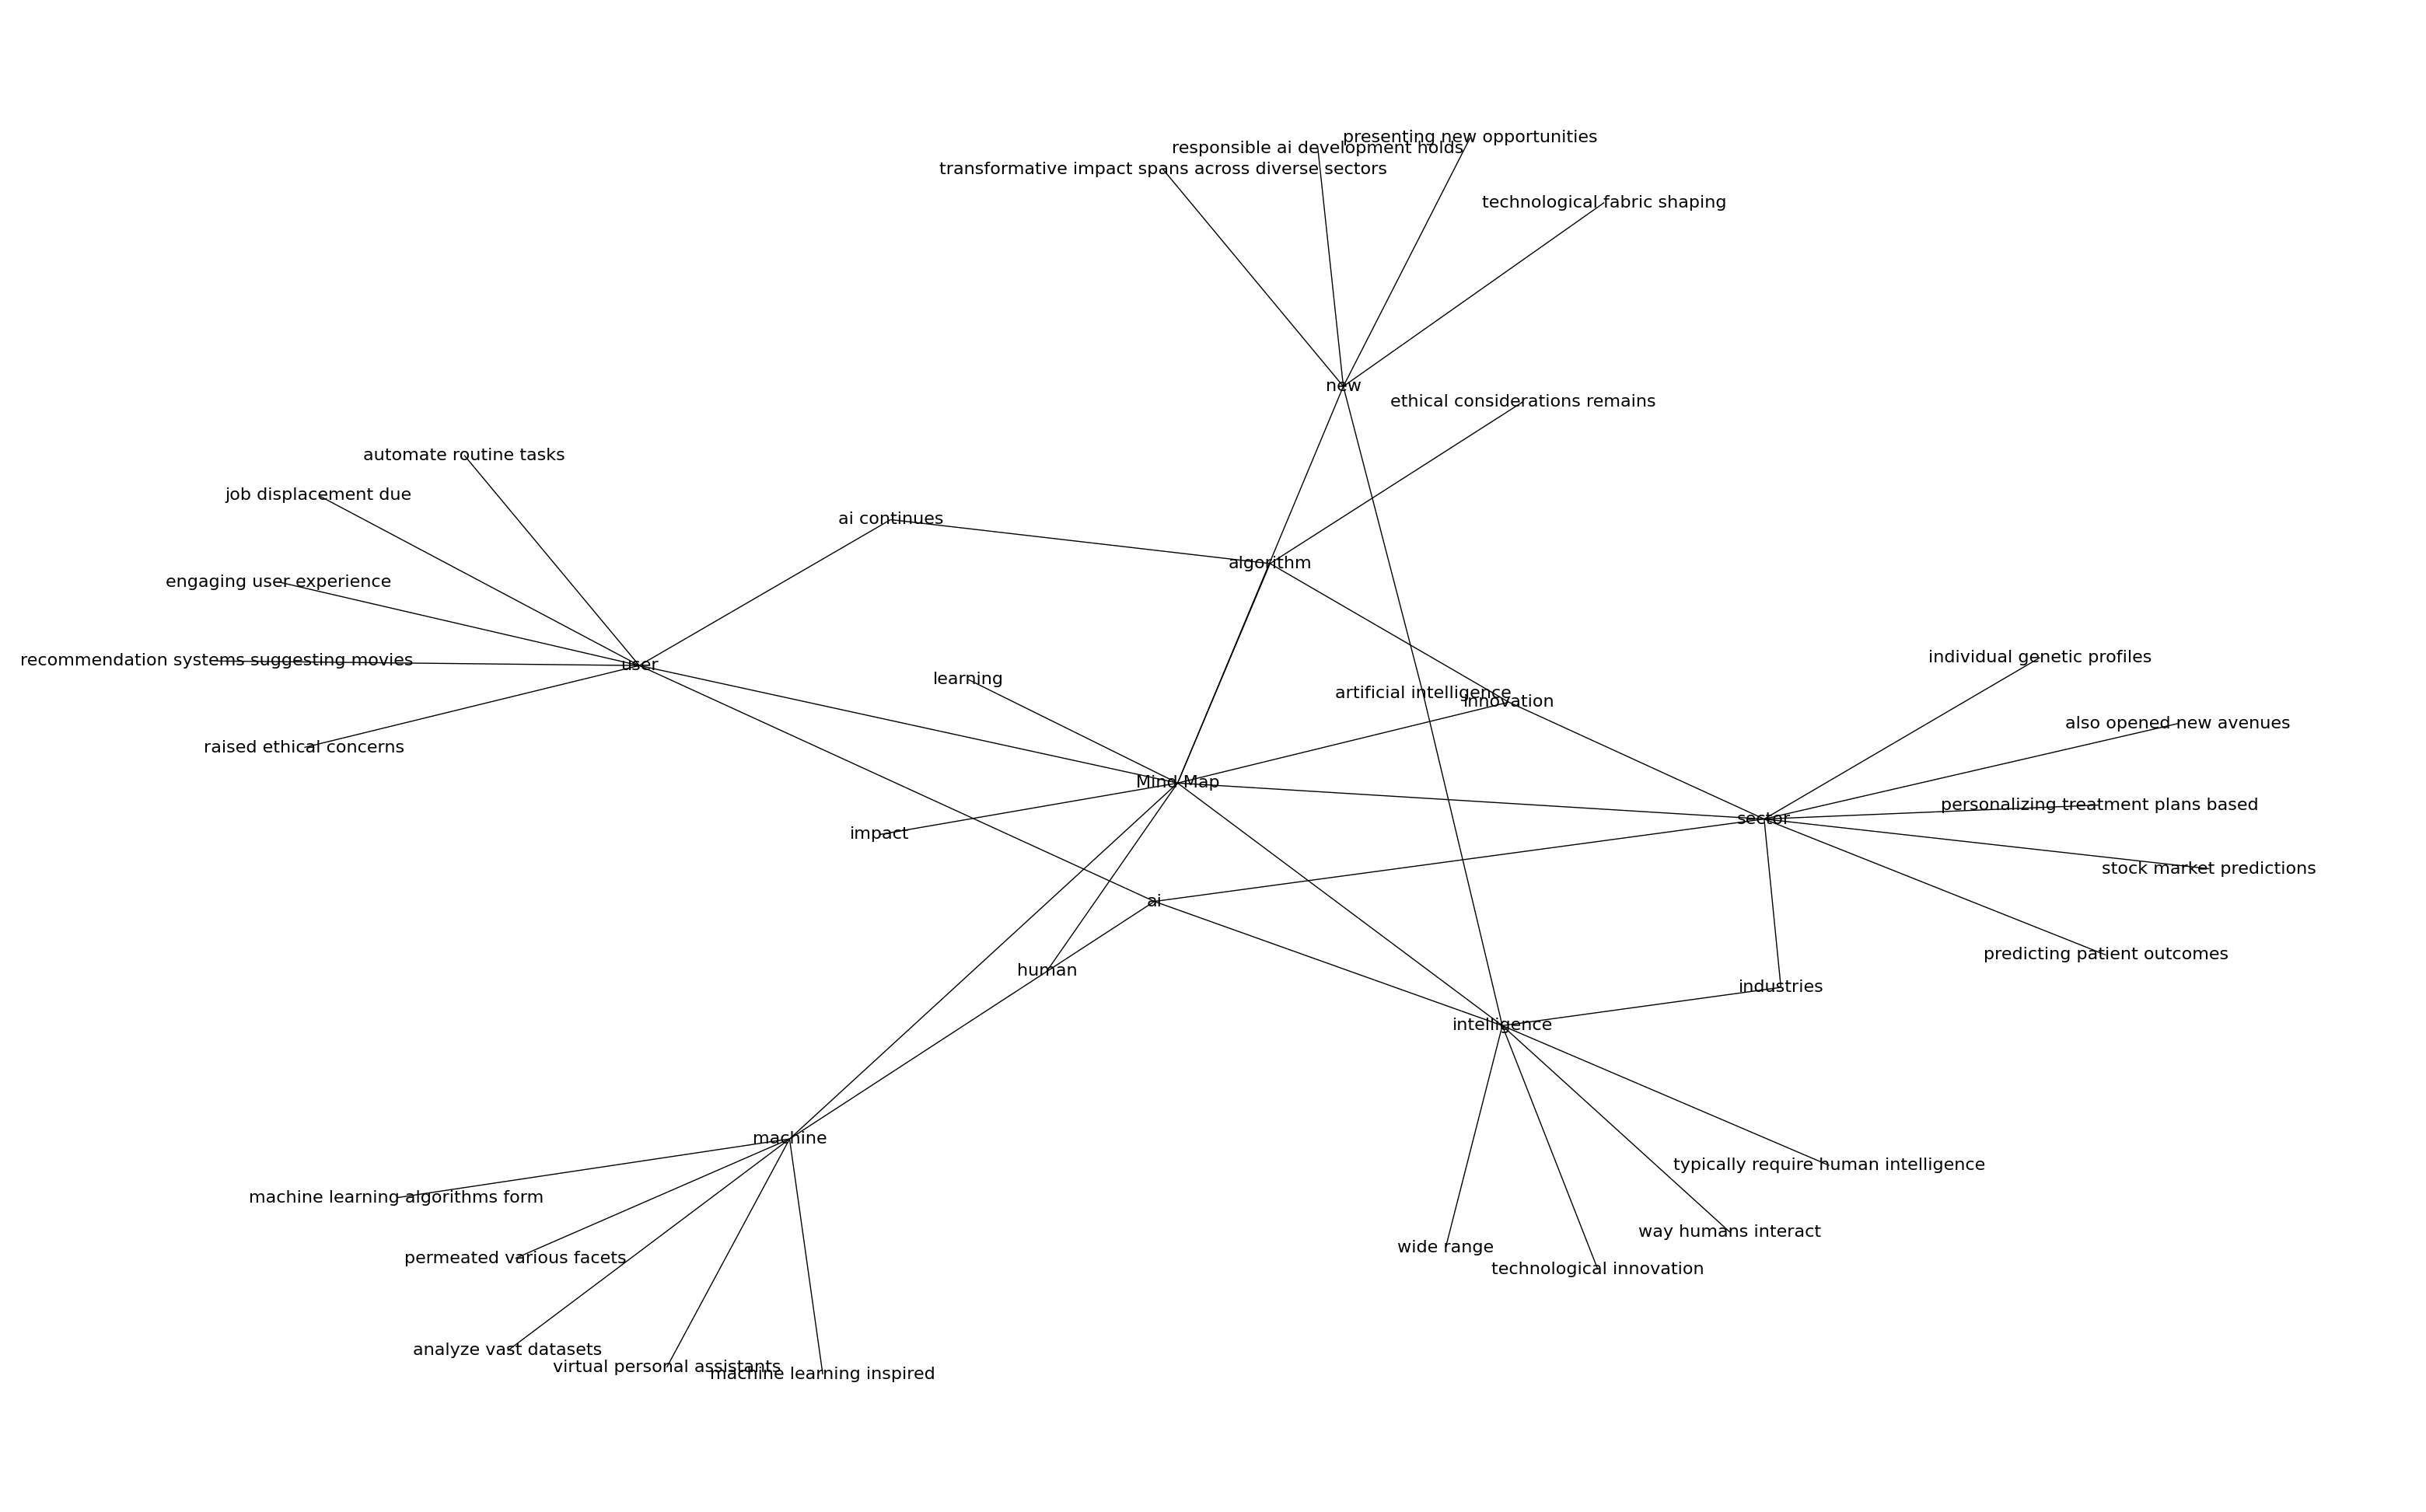

In [30]:
get_mindmap(keywords, topics)

### Test - 2 (From Text Data)

Length of text:  3233
Time taken to execute:  0.15527033805847168


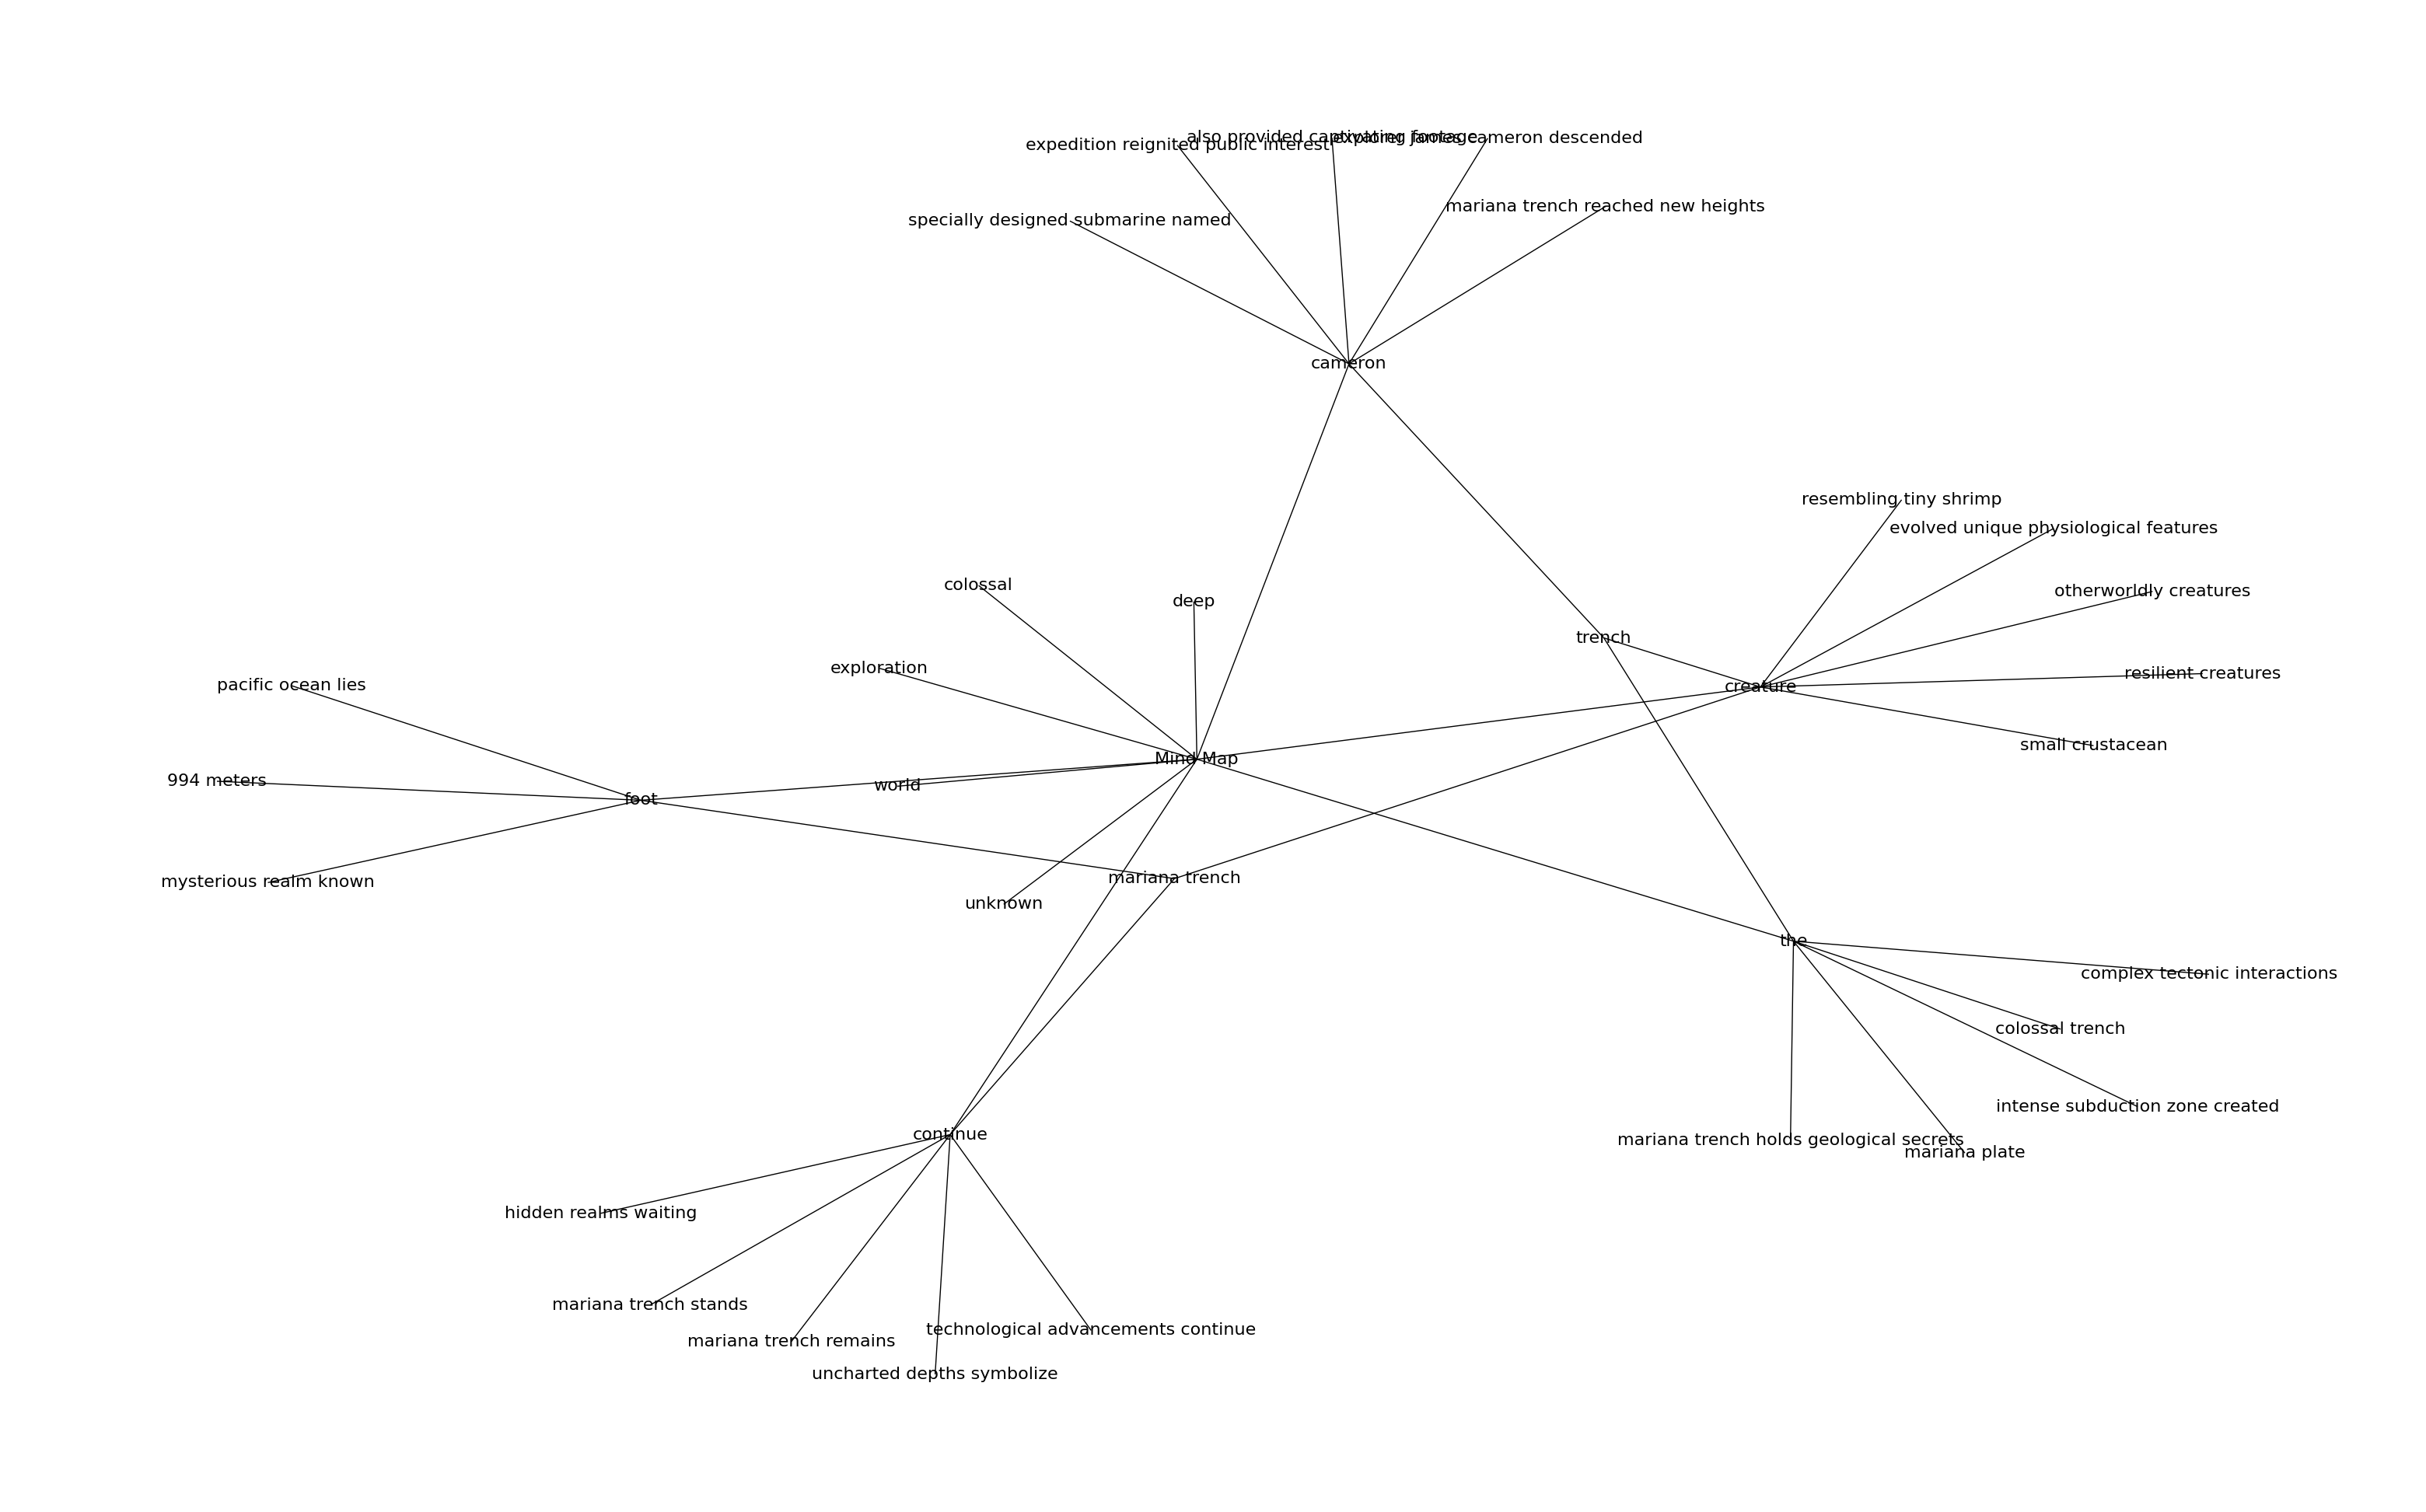

In [34]:
start_time = time.time()
final_text = load_text(r"C:\Users\manig\Downloads\Mind-Map-Generator\Python Notebook\Sample Text Files\text_file_2.txt")
print("Length of text: ", len(final_text))
keywords2, topics2 = create_keywords_from_text(final_text, max_nodes=5, sentence_group=4)
get_mindmap(keywords2, topics2)
print("Time taken to execute: ", (time.time() - start_time))

### Test - 3 (Web Scrapping)

In [32]:
start_time = time.time()

scraped_data = scrape_data('https://en.wikipedia.org/wiki/Computer_security')
final_text = clean_text(scraped_data)
print("Length of text: ", len(final_text))

summary = generate_summary(final_text, top_n=40)
summary

Length of text:  69518


"or grant physical access by , for example , impersonating a senior executive , bank , a contractor , or a customer . Vehicles are increasingly computerized , with engine timing , cruise control , anti-lock brakes , seat belt tensioners , door locks , airbags and advanced driver-assistance systems on many models . To manage the information security culture , five steps should be taken : pre-evaluation , strategic planning , operative planning , implementation , and post-evaluation . Social engineering , in the context of computer security , aims to convince a user to disclose secrets such as passwords , card numbers , etc . SMBs are most likely to be affected by malware , ransomware , phishing , man-in-the-middle attacks , and Denial-of Service ( DoS ) Attacks . Once they have access , cybercriminals can `` modify files , steal personal information , install unwanted software , and even take control of the entire computer . '' The South Korean government blamed its northern counterpart

Length of text:  69518
Time taken to execute:  2.2193477153778076


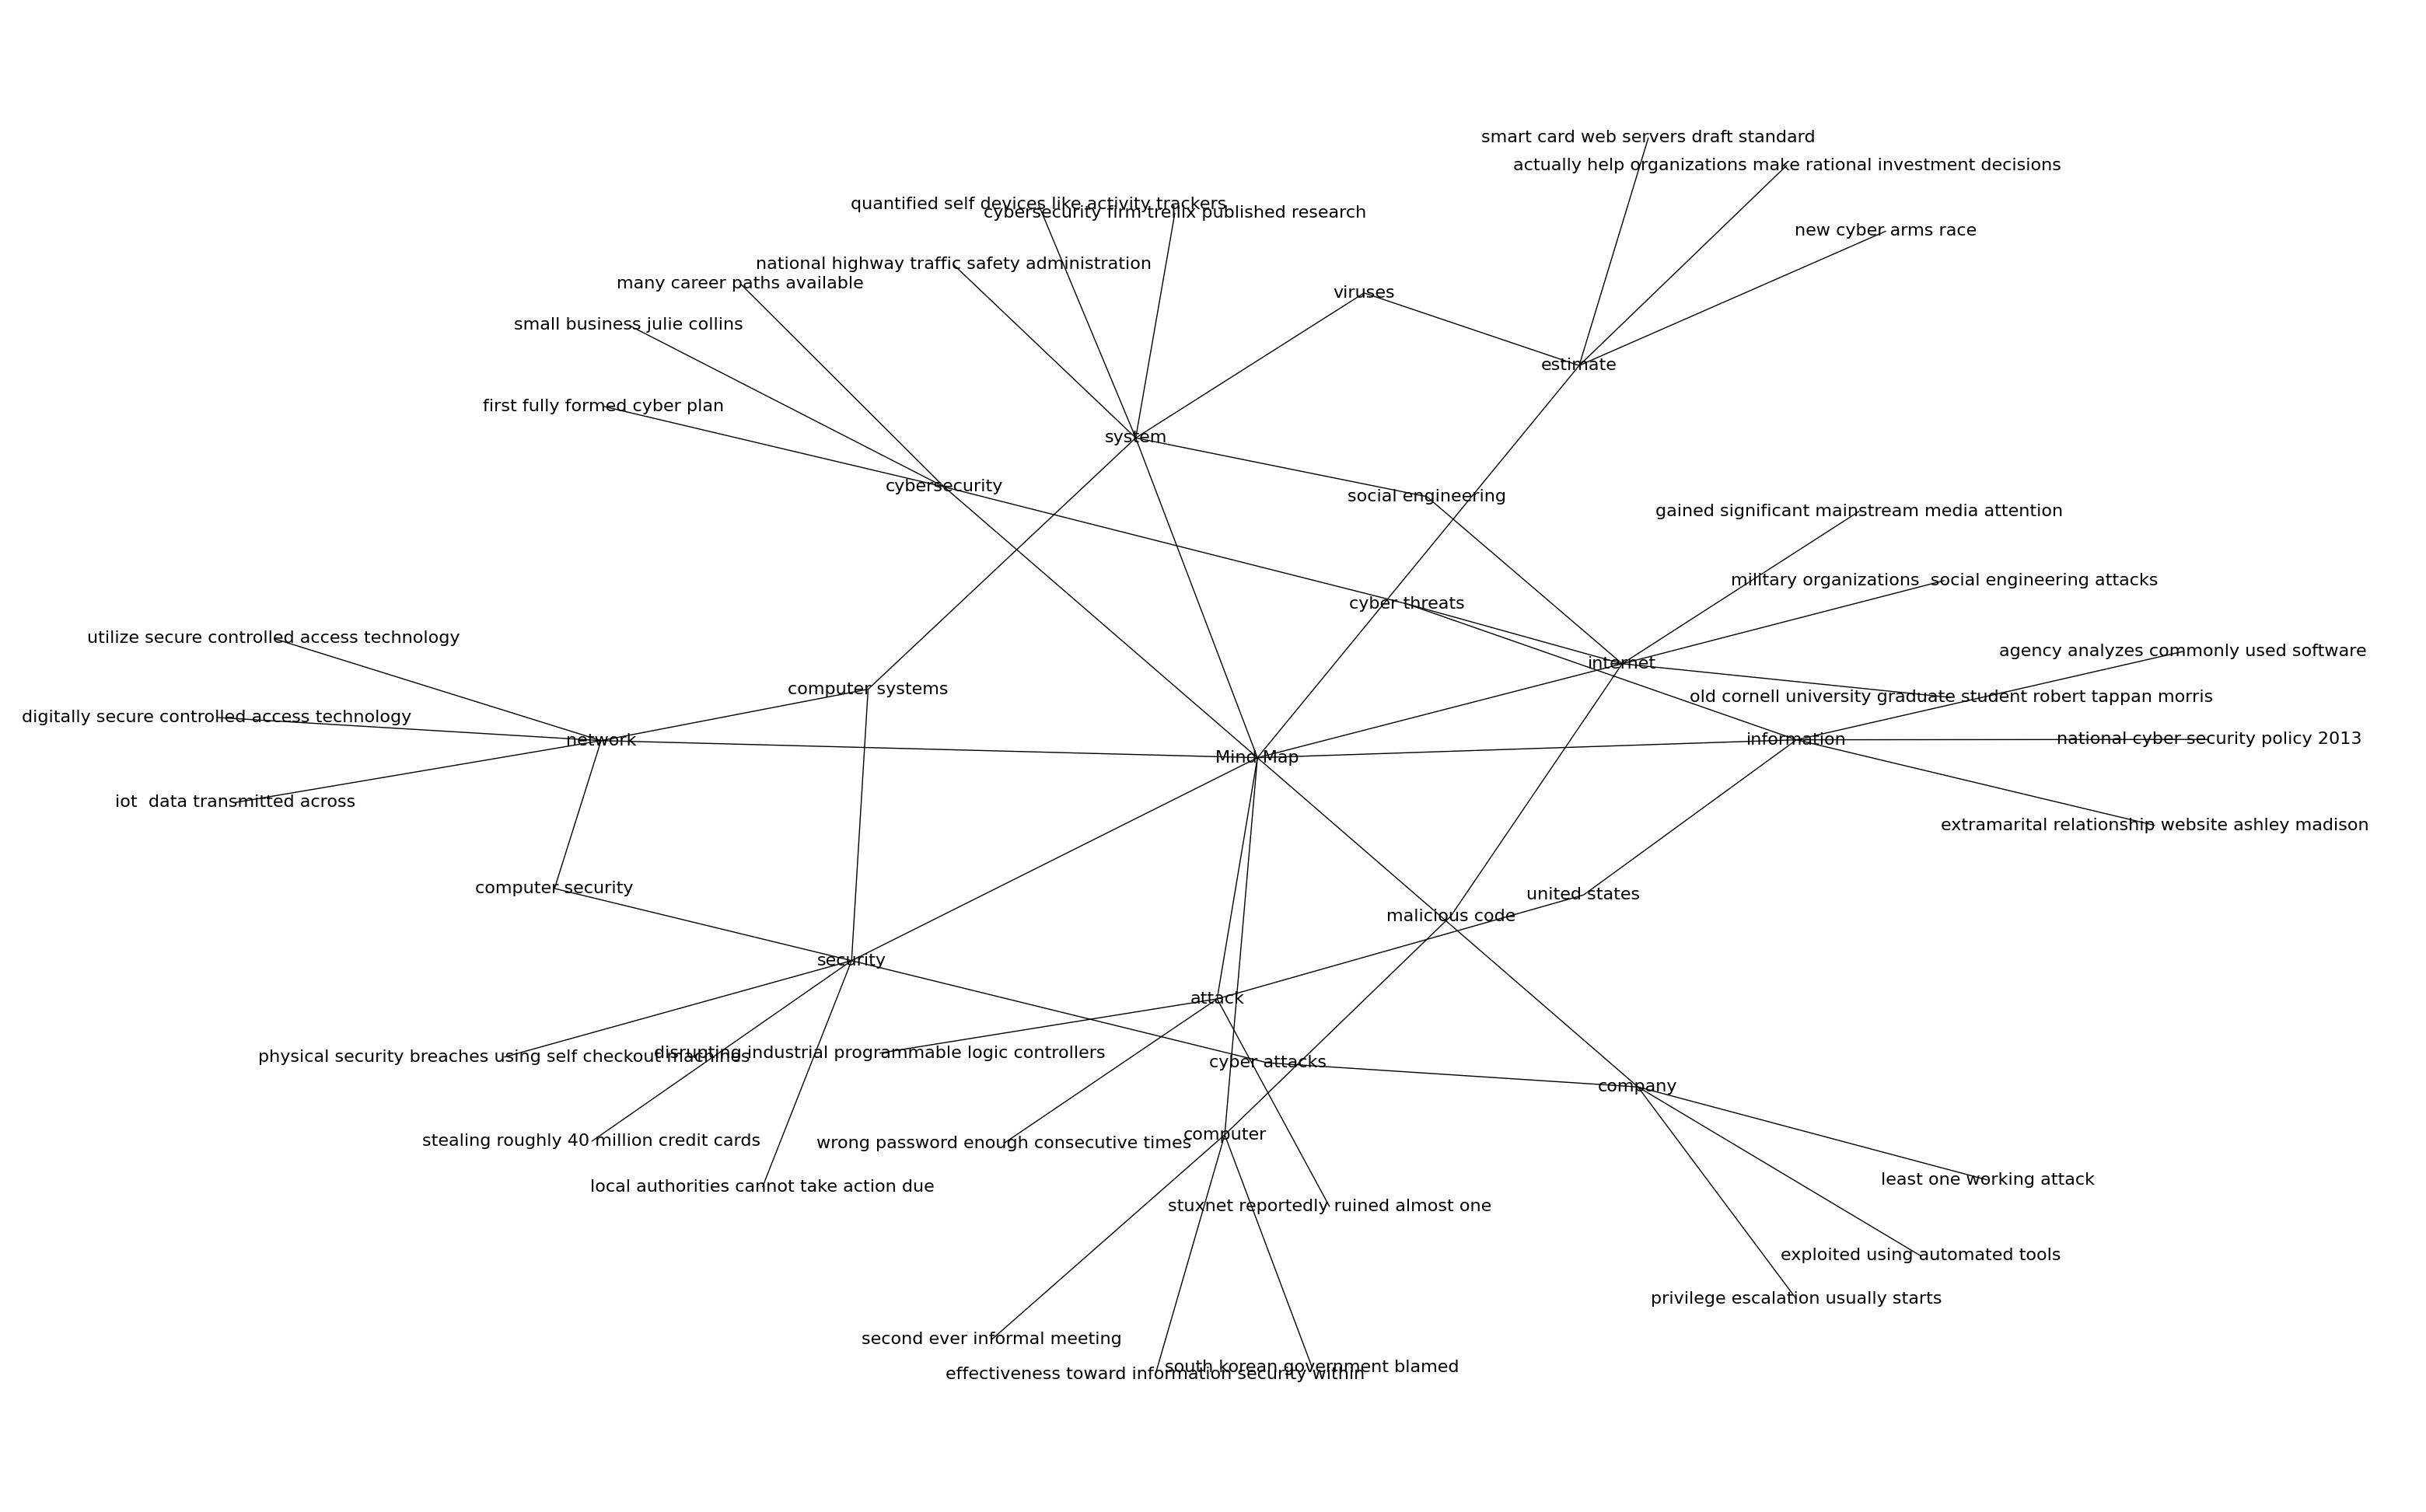

In [31]:
start_time = time.time()
scraped_data = scrape_data('https://en.wikipedia.org/wiki/Computer_security')
final_text = clean_text(scraped_data)
print("Length of text: ", len(final_text))
keywords2, topics2 = create_keywords_from_text(final_text, max_nodes=3, sentence_group=7)
get_mindmap(keywords2, topics2)
print("Time taken to execute: ", (time.time() - start_time))